In [1]:
from windisch import *
import matplotlib.pyplot as plt

In [2]:
#update_input_parameters()
tip = TurbinesInputParameters()
tip.static()
#tip.stochastic(3)
_, array = fill_xarray_from_input_parameters(
    tip,
    scope={"year": [2020, ], "size": [1000,]}
)

In [3]:
wt = WindTurbineModel(
    array,
    location=(55.602164360115104, 12.491974627997108)
)

Downloaded 420.22 kB for location (55.602164360115104, 12.491974627997108)
Onshore wind turbines


In [4]:
wt.set_all()

In [5]:
wt["average load factor"]

<xarray.DataArray (size: 1, application: 2, year: 1, value: 1)> Size: 16B
array([[[[       nan]],

        [[0.23576065]]]])
Coordinates:
  * size         (size) int64 8B 1000
  * application  (application) <U8 64B 'offshore' 'onshore'
    parameter    <U36 144B 'average load factor'
  * year         (year) int64 8B 2020
  * value        (value) int64 8B 0

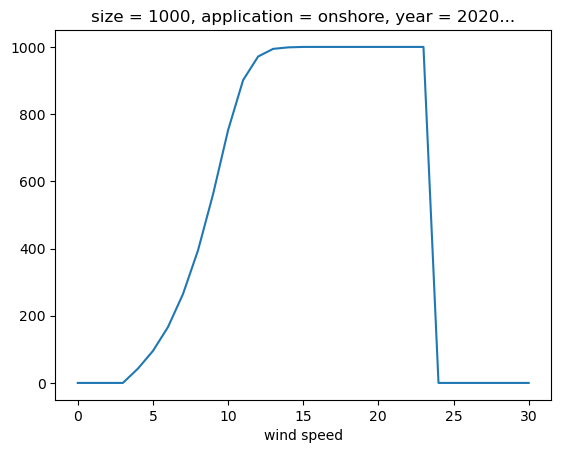

In [5]:
wt.power_curve.sel(application="onshore", year=2020).plot()

In [8]:
import pandas as pd
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326", always_xy=True)

In [32]:
dk = pd.read_excel("/Users/romain/GitHub/windisch/dev/danish_wind_turbine_registry.xlsx", header=13)

In [33]:
dk = dk.iloc[:, [3, 12, 13, 55, 56, 57, 58, 59, 60, 61]]
dk.columns = [
    "Power (kW)",
    "X",
    "Y",
    "Production 2017",
    "Production 2018",
    "Production 2019",
    "Production 2020",
    "Production 2021",
    "Production 2022",
    "Production 2023"
]
dk["Production"] = dk[[
    "Production 2017",
    "Production 2018",
    "Production 2019",
    "Production 2020",
    "Production 2021",
    "Production 2022",
    "Production 2023"
]].mean(skipna=True, axis=1)
dk = dk.loc[dk["Production"] > 0]
dk = dk.loc[dk["X"] > 0]
dk = dk.loc[dk["Power (kW)"] > 0]
dk["Load factor"] = dk["Production 2023"] / (dk["Power (kW)"] * 8760)

In [34]:
dk

,Power (kW),X,Y,Production 2017,Production 2018,Production 2019,Production 2020,Production 2021,Production 2022,Production 2023,Production,Load factor
3,660.0,719969.480,6167336.840,1320777.751,1.215273e+06,1.085841e+06,1.320225e+06,1.028473e+06,9.795441e+05,1.033811e+06,1.140564e+06,0.178811
4,660.0,720030.960,6167484.400,1170279.565,1.087014e+06,1.177463e+06,1.271935e+06,9.656586e+05,1.135906e+06,1.100627e+06,1.129840e+06,0.190367
6,660.0,704169.610,6199822.890,1028594.674,8.655286e+05,9.757116e+05,1.019166e+06,7.741376e+05,8.464748e+05,9.421950e+05,9.216869e+05,0.162964
7,660.0,704220.190,6199963.040,994858.067,8.672580e+05,9.097876e+05,7.177789e+05,7.456407e+05,8.419210e+05,9.714062e+05,8.640929e+05,0.168017
8,660.0,704270.050,6200105.680,1048761.619,8.572089e+05,8.979317e+05,9.965177e+05,7.338632e+05,8.206220e+05,7.092352e+05,8.663058e+05,0.122671
...,...,...,...,...,...,...,...,...,...,...,...,...
10637,7000.0,454407.000,6280817.000,NaN,2.429400e+07,2.980380e+07,2.970494e+07,2.675124e+07,2.963768e+07,2.632086e+07,2.775209e+07,0.429238
10639,7000.0,454153.000,6281691.000,NaN,2.429400e+07,2.980380e+07,2.970494e+07,2.675124e+07,2.963768e+07,2.632086e+07,2.775209e+07,0.429238
10658,5600.0,457413.000,6209509.000,NaN,NaN,NaN,9.845000e+03,1.455912e+07,1.967407e+07,2.260760e+07,1.421266e+07,0.460853
10659,5600.0,457512.000,6208823.000,NaN,NaN,NaN,9.845000e+03,1.455912e+07,1.967407e+07,2.260760e+07,1.421266e+07,0.460853


In [35]:
# Convert X, Y to Longitude (LON) and Latitude (LAT)
def convert_to_lat_lon(row):
    if pd.notnull(row['X']) and pd.notnull(row['Y']):
        lon, lat = transformer.transform(row['X'], row['Y'])
        return pd.Series([lon, lat])
    else:
        return pd.Series([None, None])

dk[['LAT', 'LON']] = dk.apply(convert_to_lat_lon, axis=1)

In [36]:
import numpy as np
def get_load_factor(row):
    tip = TurbinesInputParameters()
    tip.static()
    _, array = fill_xarray_from_input_parameters(
        tip,
        scope={"year": [2020, ],}
    )
    array = array.interp(size=[row["Power (kW)"]])
    wt = WindTurbineModel(
        array,
        location=(row["LON"], row["LAT"])
    )
    wt.set_all()
    return np.squeeze(np.nan_to_num(wt["average load factor"].values, 0)).max()


In [39]:
dk["Predicted load factor"] = None
dk.iloc[:50, -1] = dk.iloc[:50, :].apply(get_load_factor, axis=1)

Downloaded 420.22 kB for location (55.602164360115104, 12.491974627997108)
Onshore wind turbines
Downloaded 420.22 kB for location (55.603460031952345, 12.493066319265505)
Onshore wind turbines
Downloaded 420.21 kB for location (55.90047051860222, 12.265907282103333)
Onshore wind turbines
Downloaded 420.21 kB for location (55.90170628930182, 12.26682065232421)
Onshore wind turbines
Downloaded 420.22 kB for location (55.902964694136045, 12.267724464921168)
Onshore wind turbines
Downloaded 420.22 kB for location (55.899399749407515, 12.192420173500285)
Onshore wind turbines
Downloaded 420.22 kB for location (55.897972970160936, 12.192722437583322)
Onshore wind turbines
Downloaded 420.21 kB for location (55.89654699341272, 12.193024907446585)
Onshore wind turbines
Downloaded 420.21 kB for location (55.86770828640799, 12.287204933919098)
Onshore wind turbines
Error: HTTPSConnectionPool(host='wps.neweuropeanwindatlas.eu', port=443): Read timed out. (read timeout=25). Retrying (1/10)...
Erro

<Axes: >

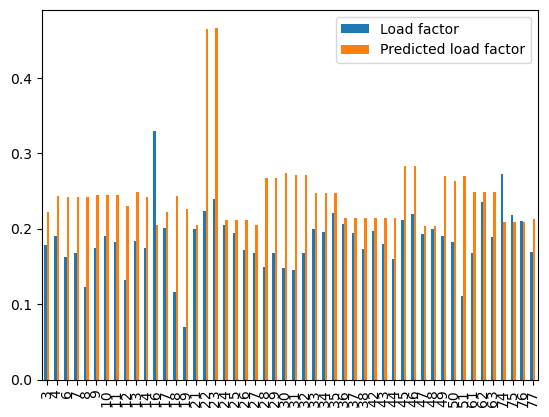

In [43]:
dk.loc[dk["Predicted load factor"] > 0, ["Load factor", "Predicted load factor"]].plot(kind="bar")

<Axes: xlabel='size,application'>

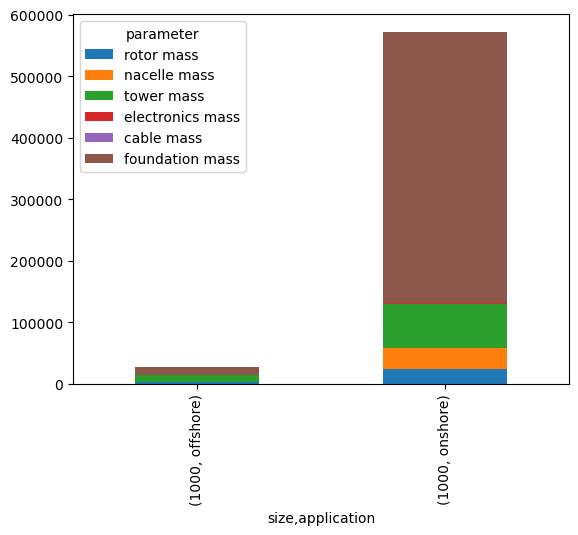

In [7]:
list_mass = [
    "rotor mass",
    "nacelle mass",
    "tower mass",
    "electronics mass",
    "cable mass",
    "foundation mass",
]
wt.array.sel(year=2020, value=0, parameter=list_mass).to_dataframe("val").unstack()["val"].plot(kind="bar", stacked=True)

In [24]:
wt.array.coords

Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
  * parameter    (parameter) <U36 'access road' ... 'turbines per farm'
  * year         (year) int64 2000 2010 2020 2030 2040 2050
  * value        (value) int64 0

In [22]:
wt.array.sel(year=2020, value=0, parameter="maintenance transport").to_dataframe("val").unstack()["val"]

application,offshore,onshore
size,,
1000kW,256779.661017,6250.0
100kW,0.000000,6250.0
3000kW,256779.661017,6250.0
500kW,0.000000,6250.0
8000kW,256779.661017,6250.0


<AxesSubplot: >

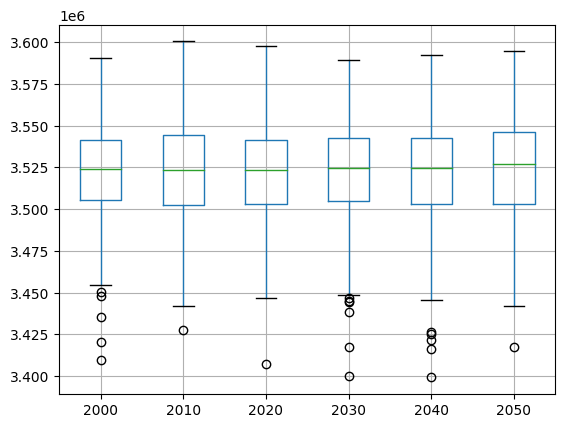

In [34]:
wt.array.sel(parameter="total mass", application="offshore", size="8000kW").to_dataframe("val").unstack()["val"].T.boxplot()

In [6]:
from windisch.model import func_tower_weight_d2h
func_tower_weight_d2h(5, 10, 3.03584782e-04, 9.68652909e00)

9762.425285500001

In [7]:
func_tower_weight_d2h(wt["rotor diameter"], wt["tower height"], 3.03584782e-04, 9.68652909e00)

<xarray.DataArray (size: 5, application: 2, year: 6, value: 1)>
array([[[[ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306]],

        [[ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994]]],


       [[[  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
...
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168]]],


       [[[840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929]],

        [[754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841]]]])
Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
  * year         (year) int64 2000 2010 2020 2030 2040 2050
  * value        (value) int64 0
    tower mass   (size, application, year, value) float64 7.337e+04 ... 7.545...

In [6]:
wt.array.sel(year=2020, value=0, parameter="tower mass")

<xarray.DataArray (size: 5, application: 2)>
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])
Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
    parameter    <U36 'tower mass'
    year         int64 2020
    value        int64 0